In [1]:
import dask
import copy
import numpy as np
import pandas as pd
import seaborn
import gensim
import dask
from gensim.models.word2vec import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams[u'font.sans-serif'] = ['Heiti TC'] + matplotlib.rcParams[u'font.sans-serif']

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
dask.config.set(scheduler='threads')

# from dask.distributed import Client
# client = Client()
# client

In [3]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.vectors / np.sqrt((model.wv.vectors ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    
    base_embed.init_sims()
    other_embed.init_sims()
#     base_embed = copy.copy(base_embed)
#     other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.vectors_norm = other_embed.wv.vectors = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors_norm = m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

@dask.delayed        
def alignModel_year(catOuter, cats): 
    embeddings_raw = {}
    for year in cats: 
        embeddings_raw[year] = Word2Vec.load(f'word2vec/word2vec_{year}.model')
    embeddings_aligned_year = [embeddings_raw[catOuter]]
    for catInner in cats: 
        embeddings_aligned_year.append(
            smart_procrustes_align_gensim(
                embeddings_aligned_year[-1], 
                embeddings_raw[catInner]
            )
        )
    return (
        embeddings_aligned_year, 
        f'{catOuter} completed Procrustes aligning. '
    )


def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - cosine_similarity(
                np.expand_dims(embeddingsDict[cat][0].wv[word], axis = 0),
                np.expand_dims(embed.wv[word], axis = 0)
            )[0,0]))
    return pd.DataFrame(dists, index=cats)

In [ ]:
# 1949 - 1969

In [4]:
cats = [year for year in range(1949, 1969)]

# cats = [year for year in range(1969, 1989)]
# cats = [year for year in range(1989, 2004)]

In [5]:
%%time
embeddings_aligned = {}
for a in range(4): 
    delayed_funcs = []
    for catOuter in cats[a * 5: (a + 1) * 5]: 
        delayed_funcs.append(alignModel_year(catOuter, cats))
    for ind, response in enumerate(dask.compute(*delayed_funcs)): 
        embeddings_aligned[cats[a * 5: (a + 1) * 5][ind]] = response[0]
        print(response[1])

1949 completed Procrustes aligning. 
1950 completed Procrustes aligning. 
1951 completed Procrustes aligning. 
1952 completed Procrustes aligning. 
1953 completed Procrustes aligning. 
1954 completed Procrustes aligning. 
1955 completed Procrustes aligning. 
1956 completed Procrustes aligning. 
1957 completed Procrustes aligning. 
1958 completed Procrustes aligning. 
1959 completed Procrustes aligning. 
1960 completed Procrustes aligning. 
1961 completed Procrustes aligning. 
1962 completed Procrustes aligning. 
1963 completed Procrustes aligning. 
1964 completed Procrustes aligning. 
1965 completed Procrustes aligning. 
1966 completed Procrustes aligning. 
1967 completed Procrustes aligning. 
1968 completed Procrustes aligning. 
CPU times: user 17min 8s, sys: 18min 29s, total: 35min 37s
Wall time: 7min 34s


In [5]:
# dask.visualize(*delayed_funcs)

经济


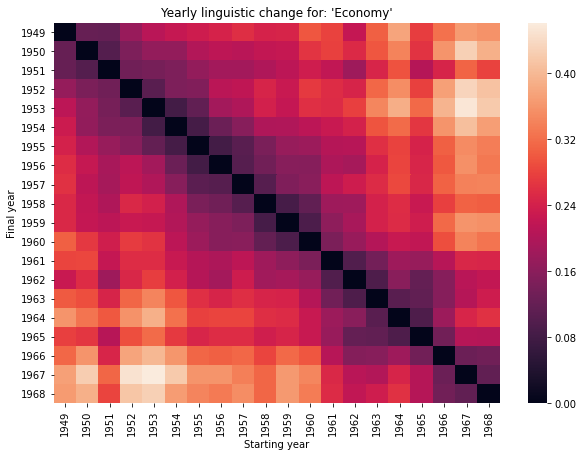

In [21]:
targetWord = '经济'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format('Economy'))
plt.show()

政治


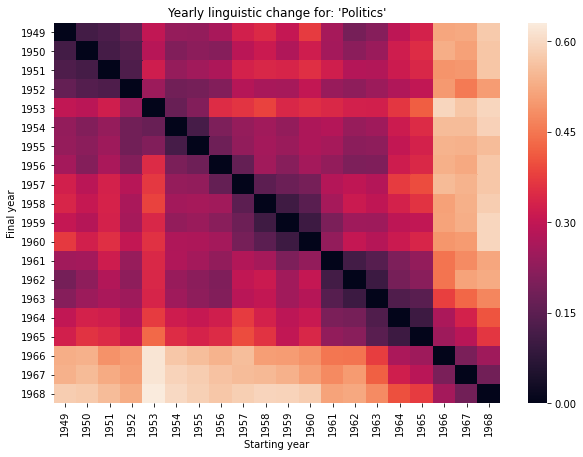

In [22]:
targetWord = '政治'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format('Politics'))
plt.show()

社会主义


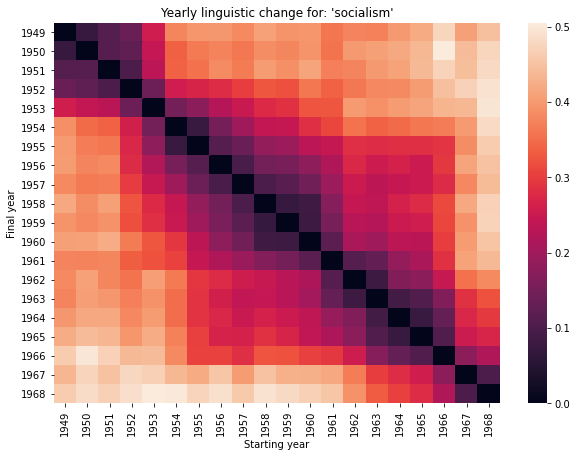

In [23]:
targetWord = '社会主义'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format('socialism'))
plt.show()

In [40]:
# 1965 - 1985
cats = [year for year in range(1965, 1985)]

In [41]:
%%time
embeddings_aligned = {}
for a in range(4): 
    delayed_funcs = []
    for catOuter in cats[a * 5: (a + 1) * 5]: 
        delayed_funcs.append(alignModel_year(catOuter, cats))
    for ind, response in enumerate(dask.compute(*delayed_funcs)): 
        embeddings_aligned[cats[a * 5: (a + 1) * 5][ind]] = response[0]
        print(response[1])

1965 completed Procrustes aligning. 
1966 completed Procrustes aligning. 
1967 completed Procrustes aligning. 
1968 completed Procrustes aligning. 
1969 completed Procrustes aligning. 
1970 completed Procrustes aligning. 
1971 completed Procrustes aligning. 
1972 completed Procrustes aligning. 
1973 completed Procrustes aligning. 
1974 completed Procrustes aligning. 
1975 completed Procrustes aligning. 
1976 completed Procrustes aligning. 
1977 completed Procrustes aligning. 
1978 completed Procrustes aligning. 
1979 completed Procrustes aligning. 
1980 completed Procrustes aligning. 
1981 completed Procrustes aligning. 
1982 completed Procrustes aligning. 
1983 completed Procrustes aligning. 
1984 completed Procrustes aligning. 
CPU times: user 20min 29s, sys: 20min 23s, total: 40min 53s
Wall time: 9min 36s


经济


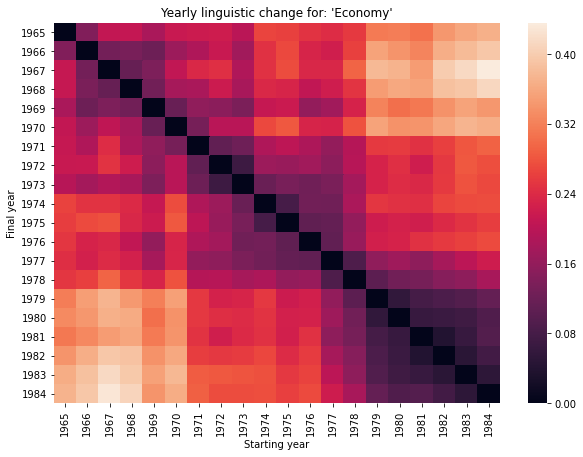

In [42]:
targetWord = '经济'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format('Economy'))
plt.show()

政治


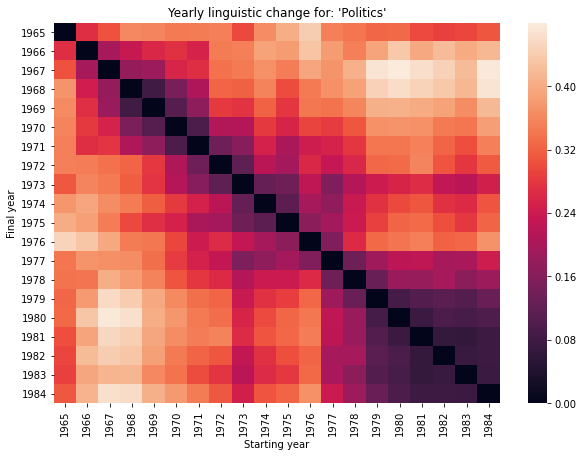

In [43]:
targetWord = '政治'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format('Politics'))
plt.show()

社会主义


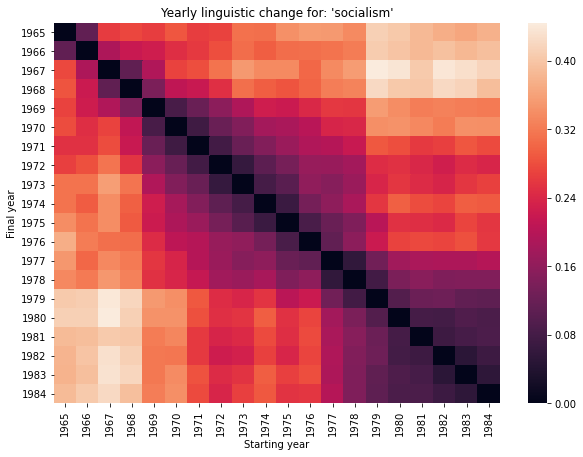

In [44]:
targetWord = '社会主义'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format('socialism'))
plt.show()

计划经济


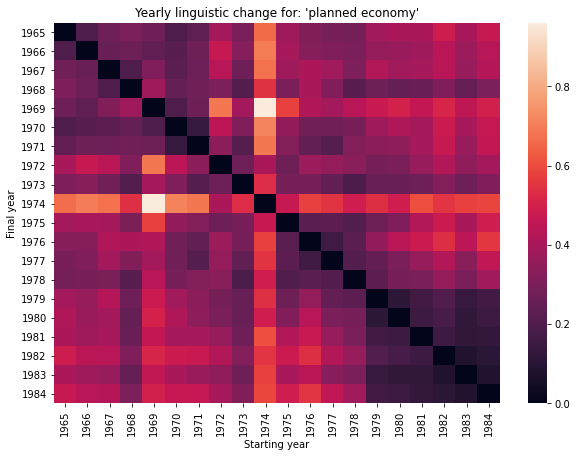

In [49]:
targetWord = '计划经济'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format('planned economy'))
plt.show()

市场


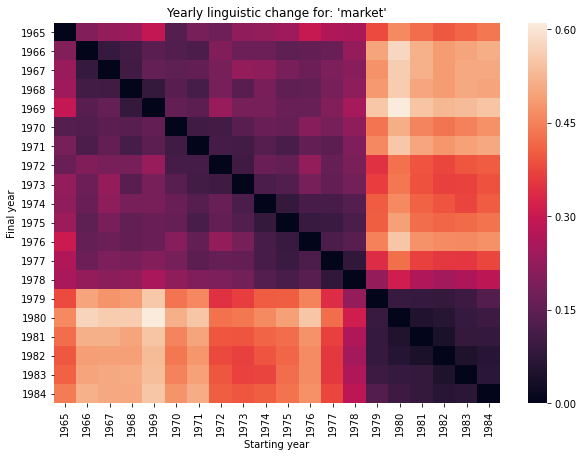

In [47]:
targetWord = '市场'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format('market'))
plt.show()

In [4]:
# 1980 - 2004
cats = [year for year in range(1984, 2004)]

In [5]:
%%time
embeddings_aligned = {}
for a in range(4): 
    delayed_funcs = []
    for catOuter in cats[a * 5: (a + 1) * 5]: 
        delayed_funcs.append(alignModel_year(catOuter, cats))
    for ind, response in enumerate(dask.compute(*delayed_funcs)): 
        embeddings_aligned[cats[a * 5: (a + 1) * 5][ind]] = response[0]
        print(response[1])

1984 completed Procrustes aligning. 
1985 completed Procrustes aligning. 
1986 completed Procrustes aligning. 
1987 completed Procrustes aligning. 
1988 completed Procrustes aligning. 
1989 completed Procrustes aligning. 
1990 completed Procrustes aligning. 
1991 completed Procrustes aligning. 
1992 completed Procrustes aligning. 
1993 completed Procrustes aligning. 
1994 completed Procrustes aligning. 
1995 completed Procrustes aligning. 
1996 completed Procrustes aligning. 
1997 completed Procrustes aligning. 
1998 completed Procrustes aligning. 
1999 completed Procrustes aligning. 
2000 completed Procrustes aligning. 
2001 completed Procrustes aligning. 
2002 completed Procrustes aligning. 
2003 completed Procrustes aligning. 
CPU times: user 25min 47s, sys: 27min 45s, total: 53min 33s
Wall time: 11min 8s


经济


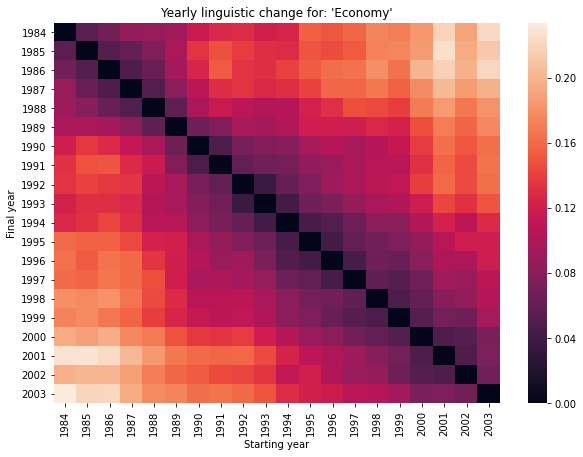

In [6]:
targetWord = '经济'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format('Economy'))
plt.show()

政治


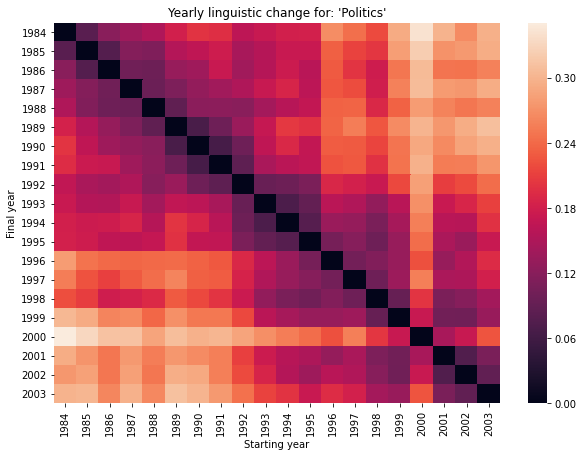

In [7]:
targetWord = '政治'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format('Politics'))
plt.show()

社会主义


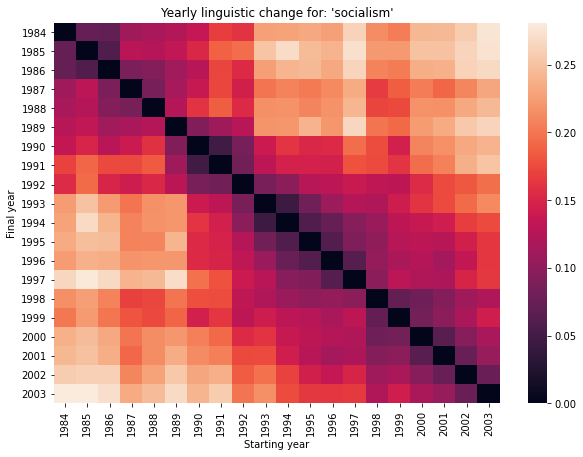

In [8]:
targetWord = '社会主义'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format('socialism'))
plt.show()

市场经济


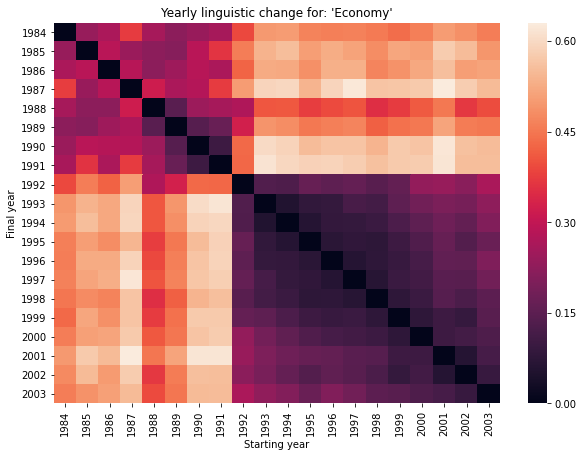

In [9]:
targetWord = '市场经济'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format('Economy'))
plt.show()

民主


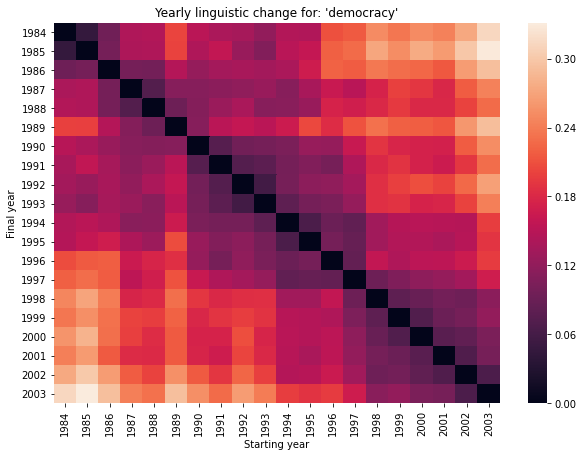

In [10]:
targetWord = '民主'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format('democracy'))
plt.show()

运动


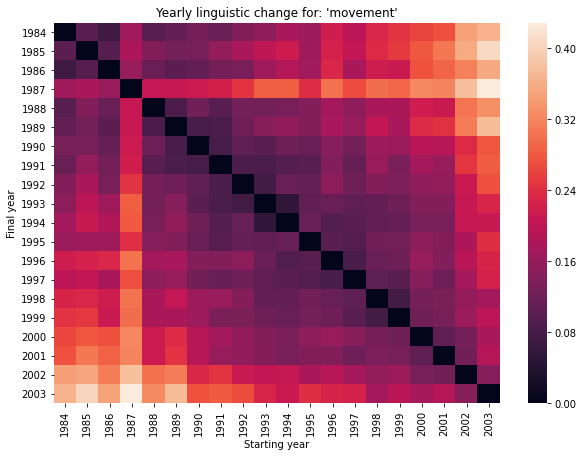

In [11]:
targetWord = '运动'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format('movement'))
plt.show()

香港


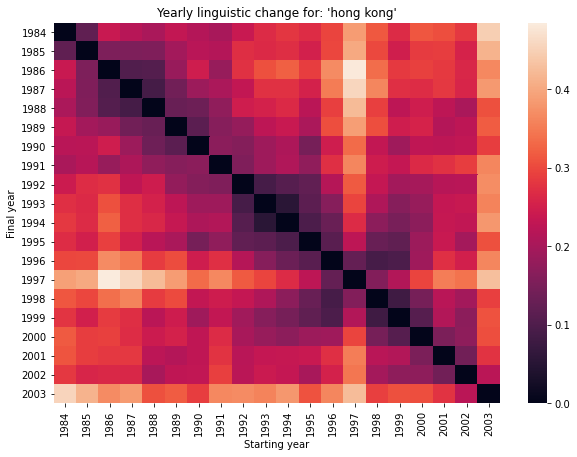

In [12]:
targetWord = '香港'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format('hong kong'))
plt.show()

## Economic Words Dynamics - convergence path

In [18]:
embeddings_raw = {}
for year in cats: 
    embeddings_raw[year] = Word2Vec.load(f'word2vec/word2vec_{year}.model')

In [19]:
%%time
from functools import reduce
common_words = reduce((lambda x, y: x & y), [embeddings_raw[year].wv.vocab.keys() for year in cats])

CPU times: user 334 ms, sys: 9.95 ms, total: 344 ms
Wall time: 340 ms


In [20]:
%%time
from functools import reduce
common_economic_words = reduce((lambda x, y: x & y), [{token[0] for token in embeddings_raw[year].wv.most_similar('经济', topn=1000)} for year in cats])

CPU times: user 8.23 s, sys: 10.9 s, total: 19.1 s
Wall time: 2.48 s


In [21]:
def semantic_vectors_dynamics_aligned_final(cats, common_words, embeddings_aligned): 
    final_year = cats[-1]
    distribution_matrix_aligned_to_final = []
    for aligned_model in embeddings_aligned[final_year][1:]:
        distribution_vector_aligned_to_final = []
        for word in common_words: 
            distribution_vector_aligned_to_final.append(aligned_model.wv[word])
        distribution_matrix_aligned_to_final.append(np.array(distribution_vector_aligned_to_final))

    # calculate Euclidean distances of each year and the final year. 
    dist_values = []
    for vector in distribution_matrix_aligned_to_final: 
        dist_values.append(
            np.linalg.norm(
                vector.reshape(-1) - distribution_matrix_aligned_to_final[-1].reshape(-1)
            )
        )
    return dist_values

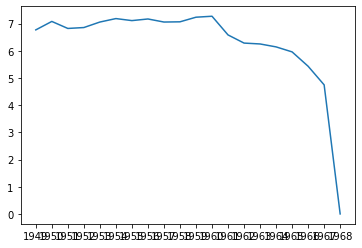

In [15]:
dist_values_aligned_final = semantic_vectors_dynamics_aligned_final(cats, common_economic_words, embeddings_aligned)
plt.plot([str(cat) for cat in cats], dist_values_aligned_final)

In [16]:
def semantic_vectors_dynamics_aligned_previous(cats, common_words, embeddings_aligned): 
    dist_values = []
    cur_year_wvs_year = []
    pre_year_wvs_year = []
    for year in cats: 
        if year == cats[0]: 
            dist_values.append(None)
        else: 
            cur_year_wvs = []
            pre_year_wvs = []
            for word in common_words: 
                cur_year_wvs.append(np.array(embeddings_aligned[year - 1][year - cats[0] + 1].wv[word]))
                pre_year_wvs.append(np.array(embeddings_aligned[year - 1][0].wv[word]))
            cur_year_wvs_year.append(np.array(cur_year_wvs))
            pre_year_wvs_year.append(np.array(pre_year_wvs))
    # calculate Euclidean distances of each year and the previous year. 
    for ind, (cur_year_wvs, pre_year_wvs) in enumerate(zip(cur_year_wvs_year, pre_year_wvs_year)): 
        dist_values.append(
            np.linalg.norm(
                cur_year_wvs.reshape(-1) - pre_year_wvs.reshape(-1)
            )
        )
    return dist_values

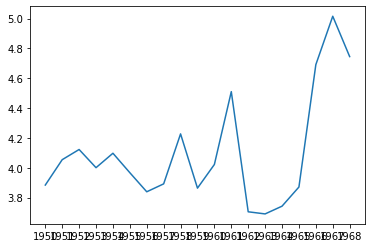

In [17]:
dist_values_aligned_pre = semantic_vectors_dynamics_aligned_previous(cats, common_economic_words, embeddings_aligned)
plt.plot([str(cat) for cat in cats], dist_values_aligned_pre)

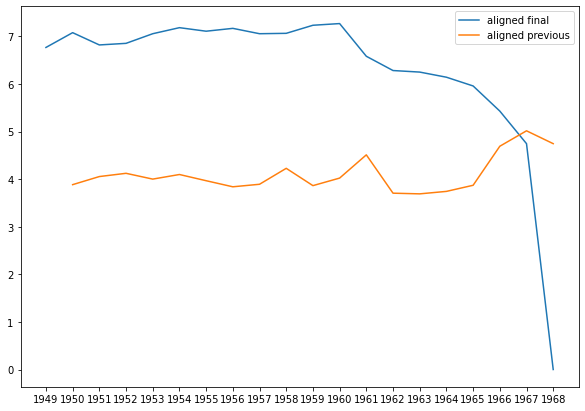

In [18]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot([str(cat) for cat in cats], dist_values_aligned_final, label='aligned final')
ax.plot([str(cat) for cat in cats], dist_values_aligned_pre, label='aligned previous')
plt.legend()

In [19]:
dist_values_aligned_final

[6.7675643,
 7.078408,
 6.8203406,
 6.85375,
 7.0561385,
 7.1832814,
 7.109001,
 7.168794,
 7.056211,
 7.0642695,
 7.2338567,
 7.269283,
 6.5822573,
 6.2824383,
 6.2499895,
 6.142195,
 5.958418,
 5.4301353,
 4.7456346,
 0.0]

In [20]:
dist_values_aligned_pre

[None,
 3.8844323,
 4.054542,
 4.1228185,
 4.0009956,
 4.0976734,
 3.9672735,
 3.8393793,
 3.8924465,
 4.227446,
 3.8638747,
 4.022502,
 4.510657,
 3.7052097,
 3.6909952,
 3.7428331,
 3.8713174,
 4.691609,
 5.016116,
 4.745634]

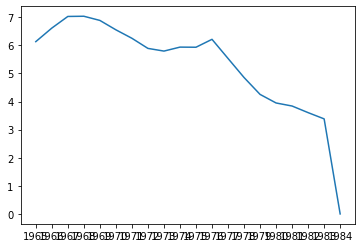

In [32]:
# 1965 - 1985
dist_values_aligned_final = semantic_vectors_dynamics_aligned_final(cats, common_economic_words, embeddings_aligned)
plt.plot([str(cat) for cat in cats], dist_values_aligned_final)

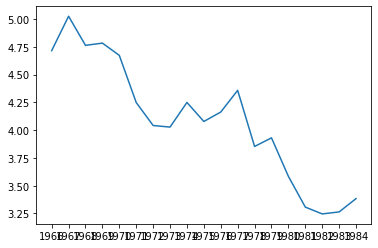

In [33]:
dist_values_aligned_pre = semantic_vectors_dynamics_aligned_previous(cats, common_economic_words, embeddings_aligned)
plt.plot([str(cat) for cat in cats], dist_values_aligned_pre)

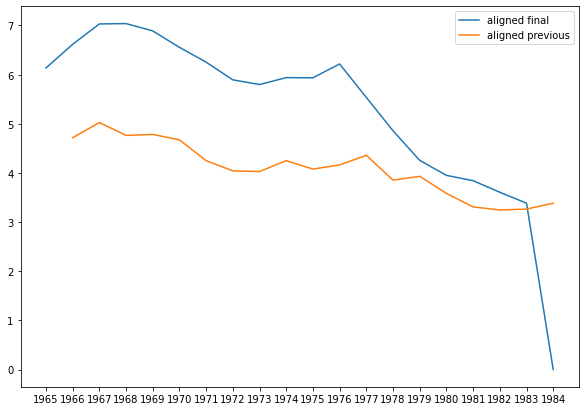

In [34]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot([str(cat) for cat in cats], dist_values_aligned_final, label='aligned final')
ax.plot([str(cat) for cat in cats], dist_values_aligned_pre, label='aligned previous')
plt.legend()

In [35]:
dist_values_aligned_final

[6.1339116,
 6.616256,
 7.0306964,
 7.0381355,
 6.889403,
 6.554869,
 6.253399,
 5.8932853,
 5.797661,
 5.9388905,
 5.934671,
 6.216143,
 5.5352387,
 4.8570247,
 4.2552857,
 3.94995,
 3.8413427,
 3.6060834,
 3.3837044,
 0.0]

In [36]:
dist_values_aligned_pre

[None,
 4.7150345,
 5.0246305,
 4.762752,
 4.7829967,
 4.6724777,
 4.2482743,
 4.0415187,
 4.0271416,
 4.24899,
 4.0778155,
 4.1627464,
 4.3575807,
 3.8528569,
 3.9303677,
 3.583934,
 3.3073387,
 3.2459195,
 3.2638075,
 3.3837042]

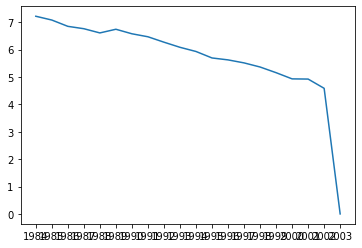

In [22]:
# 1980 - 2004
dist_values_aligned_final = semantic_vectors_dynamics_aligned_final(cats, common_economic_words, embeddings_aligned)
plt.plot([str(cat) for cat in cats], dist_values_aligned_final)

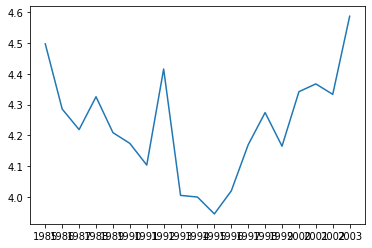

In [23]:
dist_values_aligned_pre = semantic_vectors_dynamics_aligned_previous(cats, common_economic_words, embeddings_aligned)
plt.plot([str(cat) for cat in cats], dist_values_aligned_pre)

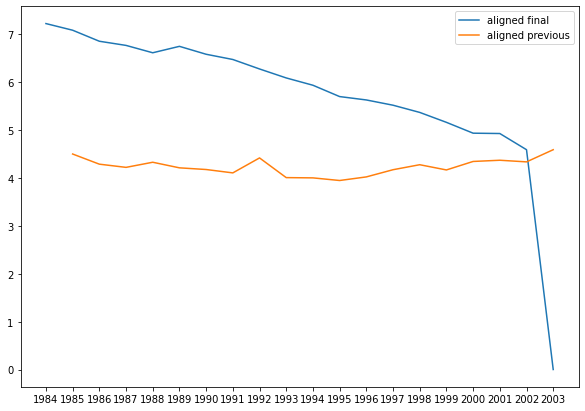

In [24]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot([str(cat) for cat in cats], dist_values_aligned_final, label='aligned final')
ax.plot([str(cat) for cat in cats], dist_values_aligned_pre, label='aligned previous')
plt.legend()